# GW AGN Example

In [1]:
import numpy as np
from astropy.table import Table, vstack, hstack
from astropy.coordinates import SkyCoord
import astropy.units as u
import sys, os
sys.path.append('/mnt/rdliang/AGN/BBH_AGN/Cmash')
import Cmash
from astropy.time import Time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KernelDensity
import warnings
from tqdm import tqdm
warnings.simplefilter("ignore")
plt.style.use('seaborn-v0_8-colorblind')

## O4a: Cross-match EP Known Source with AGN flare detected in Optical

In [5]:
agn_flare_table = Table.read('/mnt/rdliang/AGN/BBH_AGN/data/AGNflares.csv')
agn_flare_cat = SkyCoord(agn_flare_table['RA'],agn_flare_table['DEC'],unit=u.deg)

EP_source_table = Table.read('/mnt/rdliang/AGN/BBH_AGN/data/stp_source_list.csv')
EP_source_cat = SkyCoord(EP_source_table['RA'],EP_source_table['Dec'],unit=u.deg)

source_matched_idx, cat_matched_idx = Cmash.match_cat(agn_flare_cat,EP_source_cat,radius=3*u.arcmin)

agn_flare_matched, EP_source_matched = agn_flare_table[source_matched_idx], EP_source_table[cat_matched_idx]
matched_table = hstack((agn_flare_matched,EP_source_matched))
matched_table.write('/mnt/rdliang/AGN/BBH_AGN/data/AGNflare_EP_matched.csv',format='csv')

## EP Known Source Statistics

In [2]:
#Load Source List
wxt_known_source_cat = pd.read_csv('/mnt/rdliang/AGN/BBH_AGN/data/wxt_known_source_list.csv').rename(columns={'Source Name':'Common Name'})
transient_cat = pd.read_csv('/mnt/rdliang/AGN/BBH_AGN/data/transient_list.csv')
stellar_flare_cat = pd.read_csv('/mnt/rdliang/AGN/BBH_AGN/data/stellar_flare_list.csv')
all_source = wxt_known_source_cat.merge(transient_cat,how='outer')
all_source = all_source.merge(stellar_flare_cat,how='outer')

categories = np.unique(all_source['Category'].replace({np.nan:'Unclassified','X-ray Binary':'XRB','Unclassfied':'Unclassified'}))
property_flux = {cat:0 for cat in categories}

for cat in categories:
    print('%s : %s'%(cat,len(all_source[all_source['Category']==cat])))
    property_flux[cat] = all_source[all_source['Category']==cat]['Last Observed Flux'].to_numpy()

AGN : 1760
CV : 170
Cluster of Galaxies : 473
GRB : 26
Galaxy : 189
Nova : 5
Pulsar : 56
SNR : 71
Star : 2975
Star Cluster : 12
Supernovae : 2
TDE : 3
Unclassified : 508
Unverified : 7426
XRB : 439


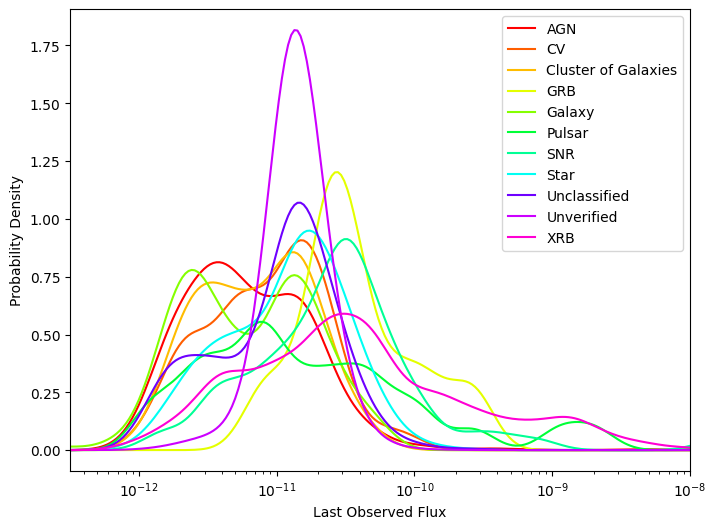

In [13]:
#Flux histogram per category
cmap = plt.get_cmap('hsv', len(categories)+2)
cat_color = {cat:mpl.colors.rgb2hex(cmap(i)) for i,cat in enumerate(categories)}
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
bins = np.logspace(-12.5,-8,20)
x_plot = np.logspace(-12.5,-8,200)
for i,cat in enumerate(categories):
    data = property_flux[cat]
    if len(data) < 20:
        continue
    data = data[data != 0]
    data = np.log10(data).reshape(-1,1)
    #data[~np.isfinite(data)] = -10
    kde = KernelDensity(kernel='gaussian', bandwidth=0.15).fit(data)
    log_dens = kde.score_samples(np.log10(x_plot).reshape(-1,1))
    ax.plot(x_plot,np.exp(log_dens),color=cat_color[cat],label=cat)
    #ax.hist(property_flux[cat],bins=bins,histtype='step',color=cat_color[cat],density=True)
    #ax.hist(property_flux[cat],bins=bins,histtype='bar',color=cat_color[cat],alpha=0.3,density=True)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(min(bins),max(bins))
ax.set_ylabel('Probability Density')
ax.set_xlabel('Last Observed Flux')
ax.legend()
plt.savefig('/mnt/rdliang/AGN/BBH_AGN/figures/xflux_stat.png',dpi=300)

In [15]:
#redshift distribution
from astroquery.simbad import Simbad
# 确保查询包含红移字段
Simbad.add_votable_fields('rvz_redshift')

all_source['redshift'] = np.empty(all_source.shape[0])
for i in tqdm(range(all_source.shape[0]),):
    name = all_source.loc[i,'Common Name']
    result = Simbad.query_object(name)
    if name is not None:
        try:
            redshift = result['rvz_redshift'][0]
            all_source.loc[i,'redshift'] = redshift
        except:
            #tqdm.write('No redshift information of %s on SIMBAD'%name)
            # print('No redshift information of %s on SIMBAD'%name,file=sys.stderr)
            all_source.loc[i,'redshift'] = None
all_source.to_csv('/mnt/rdliang/AGN/BBH_AGN/data/all_source.csv')

KeyboardInterrupt: 

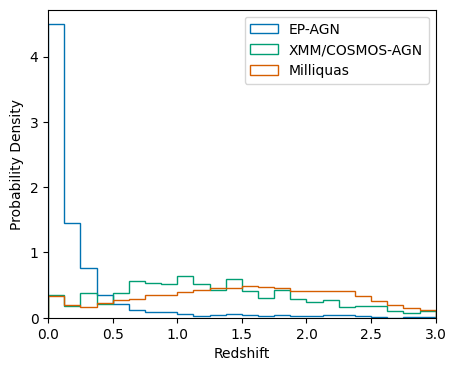

In [10]:
from astroquery.vizier import Vizier
vizier = Vizier() # this instantiates Vizier with its default parameters
vizier.ROW_LIMIT = 1e3
xmm_agn = vizier.get_catalogs("J/ApJ/742/61/table5")
milliquas_cat = Table.read('/mnt/rdliang/AGN/BBH_AGN/data/Milliquas.csv',format='csv')
all_source = pd.read_csv('/mnt/rdliang/AGN/BBH_AGN/data/all_source.csv')

fig,ax = plt.subplots(figsize=(5,4))
plot_category = ['AGN']
bins = np.linspace(0,3,25)
for cat in plot_category:
    ax.hist(all_source[all_source['Category']==cat]['redshift'],bins=bins,histtype='step',density=True,label='EP-'+cat)
ax.hist(xmm_agn[0]['zph'],bins=bins,histtype='step',density=True,label='XMM/COSMOS-AGN')
ax.hist(milliquas_cat['Z'][milliquas_cat['Z']<3],bins=bins,histtype='step',density=True,label='Milliquas')
ax.set_xlabel('Redshift')
ax.set_ylabel('Probability Density')
#ax.set_yscale('log')
ax.set_xlim(0,max(bins))
ax.legend()
plt.savefig('/mnt/rdliang/AGN/BBH_AGN/figures/AGN_z.png',dpi=300)

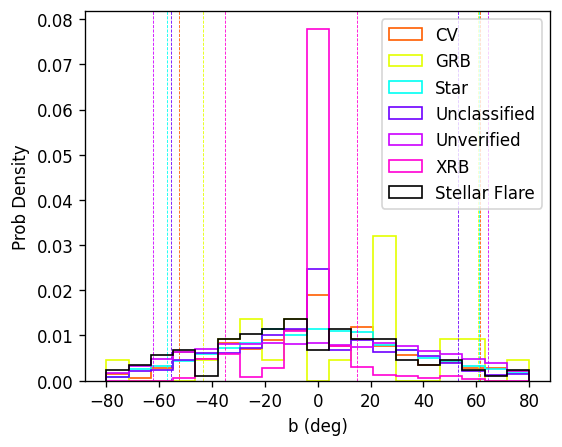

In [18]:
fig, ax = plt.subplots(figsize=(5,4),dpi=120)
bins = np.linspace(-80,80,20)
cmap = plt.get_cmap('hsv', len(categories)+2)
cat_color = {cat:mpl.colors.rgb2hex(cmap(i)) for i,cat in enumerate(categories)}
exGal = ['AGN','Cluster of Galaxies','Galaxy','Pulsar','SNR','Star Cluster','Nova','Supernovae','TDE']
for i,cat in enumerate(categories):
    if cat in exGal:
        continue
    c = SkyCoord(all_source[all_source['Category']==cat]['RA'],all_source[all_source['Category']==cat]['Dec'],unit=u.deg)
    b = c.galactic.b.deg
    Q5, Q95 = np.quantile(b,0.05), np.quantile(b,0.95)
    ax.hist(b,bins,histtype='step',color=cat_color[cat],label=cat,density=True)
    ax.axvline(Q5,0,1,color=cat_color[cat],ls='--',lw=0.5)
    ax.axvline(Q95,0,1,color=cat_color[cat],ls='--',lw=0.5)
    
c_sf = SkyCoord(all_source[all_source['Tags']=='["stellar_flare"]']['RA'],all_source[all_source['Tags']=='["stellar_flare"]']['Dec'],unit=u.deg)
b_sf = c_sf.galactic.b.deg
ax.hist(b_sf,histtype='step',bins=bins,density=True,color='k',label='Stellar Flare')
ax.set_xlabel('b (deg)')
ax.set_ylabel('Prob Density')
ax.legend(loc='upper right')
plt.savefig('/mnt/rdliang/AGN/BBH_AGN/figures/galsource_b.png',dpi=300)

In [11]:
all_source['Tags'][4] == '["stellar_flare"]'

True

## Known Source Data Clean

In [32]:
agn_table = Table.read('/mnt/rdliang/AGN/BBH_AGN/data/Milliquas.csv')
agn_cat = SkyCoord(agn_table['RA'],agn_table['DEC'],unit=u.deg)

EP_source_table = Table.read('/mnt/rdliang/AGN/BBH_AGN/data/stp_source_list.csv')
EP_source_cat = SkyCoord(EP_source_table['RA'],EP_source_table['Dec'],unit=u.deg)

source_matched_idx, cat_matched_idx, sep = Cmash.match_cat(agn_cat,EP_source_cat,radius=3*u.arcmin,seperation=True)

agn_matched, EP_source_matched = agn_table[source_matched_idx], EP_source_table[cat_matched_idx]
matched_table = hstack((agn_matched,EP_source_matched))
matched_table['sep(arcmin)'] = sep.arcmin
matched_table.write('/mnt/rdliang/AGN/BBH_AGN/data/AGN_EP_matched.csv',format='csv',overwrite=True)

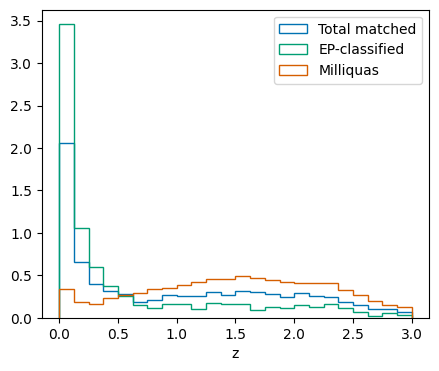

In [33]:
matched_table = Table.read('/mnt/rdliang/AGN/BBH_AGN/data/AGN_EP_matched.csv',format='csv')
fig, ax = plt.subplots(figsize=(5,4),dpi=100)
bins = np.linspace(0,3,25)
ax.hist(matched_table['Z'],bins=bins,density=True,histtype='step',label='Total matched')
ax.hist(matched_table[matched_table['Category']=='AGN']['Z'],bins=bins,density=True,histtype='step',label='EP-classified')
ax.hist(milliquas_cat['Z'][milliquas_cat['Z']<3],bins=bins,histtype='step',density=True,ls='--',label='Milliquas')
ax.set_xlabel('z')
ax.legend()
#plt.savefig('/mnt/rdliang/AGN/BBH_AGN/figures/EP_matched_AGN.png',dpi=300)

In [34]:
print('Matched total: %s'%len(matched_table))
print('EP-AGN: %s'%len(EP_source_table[EP_source_table['Category']=='AGN']))
print('Matched EP-classified AGN: %s'%len(np.unique(matched_table[matched_table['Category']=='AGN']['Source Name'])))

Matched total: 4460
EP-AGN: 1746
Matched EP-classified AGN: 1574


In [35]:
matched_table[matched_table['Category']=='AGN']

RA_1,DEC,NAME,TYPE,RMAG,BMAG,COMMENT,R,B,Z,CITE,ZCITE,XNAME,RNAME,LOBE1,LOBE2,col0,Source Name,RA_2,Dec,Obs Time (UTC),Goto,Detail,Tags,Category,CL,R_Flux,sep(arcmin)
float64,float64,str25,str4,float64,float64,str3,str1,str1,float64,str6,str6,str22,str22,str22,str22,int64,str32,float64,float64,str20,int64,int64,str24,str19,str29,float64,float64
0.04886,5.388198,RXS J00001+0523,AX,15.550000190734863,16.889999389648438,pG,1,1,0.03999999910593033,2130,2130,LSXPS J000011.7+052318,--,--,--,--,LEDA 3095388,0.04885994665,5.38819854583,--,--,--,"[""known_source""]",AGN,Seyfert 1,4.99e-12,3.290448983568927e-05
0.6100838,3.3519262,MARK 543,ARX,9.770000457763672,11.050000190734863,p+G,-,-,0.026000000536441803,1170,1502,LSXPS J000226.2+032108,RACS J000226.4+032109,--,--,--,NGC 7811,0.61008436902,3.35192811058,--,--,--,"[""known_source""]",AGN,Seyfert 1,1.31e-11,0.00011959420602976225
0.6439901,3.358214,SDSS J000234.56+032129.4,QX,19.540000915527344,19.6200008392334,gG,-,-,2.3980000019073486,DR16Q,DR16Q,LSXPS J000234.2+032129,--,--,--,--,NGC 7811,0.61008436902,3.35192811058,--,--,--,"[""known_source""]",AGN,Seyfert 1,1.31e-11,2.0655810329387907
1.0082414,70.3217522,IGR J00040+7020,NRX,17.360000610351562,20.540000915527344,p,-,1,0.09600000083446503,1212,1212,4XMM J000401.9+701918,VLAJ000401.96+701918.1,NVSS J000402.1+701916,LSXPS J000401.9+701918,--,IGR J00040+7020,1.00834682,70.32171913,--,--,--,"[""known_source""]",AGN,Seyfert 2 Galaxy,5.53e-12,0.0029109578685901196
1.2435247,11.700909,UGC 32,NRX,10.270000457763672,14.359999656677246,p+,1,1,0.07400000095367432,0139,0994,1RXH J000457.9+114201,VLAJ000458.44+114203.3,FIRST J000458.4+114203,RACS J000458.4+114204,--,UGC 32,1.2435346,11.7009097,--,--,--,"[""known_source""]",AGN,Seyfert 1,1.5e-11,0.0005831708253143023
1.4294877,-50.1152445,RXS J00057-5007,AX,12.869999885559082,12.600000381469727,jG,1,-,0.032999999821186066,0528,0528,LSXPS J000542.9-500655,--,--,--,--,LEDA 407,1.42948600405,-50.11524471164,--,--,--,"[""known_source""]",AGN,Seyfert 1,2.29e-11,6.647533920477584e-05
1.4968249,16.1636176,PKS 0003+15,Q2X,16.309999465942383,16.200000762939453,pG,-,-,0.44999998807907104,1636,0220,4XMM J000559.2+160949,--,VLAJ000558.85+160951.3,VLAJ000600.15+160942.2,--,ICRF J000559.2+160949,1.49682439391,16.16361721336,--,--,--,"[""known_source""]",AGN,AGN,2.86e-11,3.726616942918715e-05
1.5814049,20.2029493,KUG 0003+199,ARX,11.229999542236328,11.960000038146973,p+G,1,1,0.026000000536441803,PGC,0743,4XMM J000619.5+201210,VLAJ000619.52+201210.7,ILDJ000619.50+201210.9,NVSS J000619.4+201210,--,Mrk 335,1.58140514126,20.20294927891,--,--,--,"[""known_source""]",AGN,Seyfert 1 Galaxy,1.29e-11,1.3643799034089978e-05
1.652359,43.7078608,RXS J00066+4342,AX,13.40999984741211,14.229999542236328,pG,1,-,0.16599999368190765,0708,0708,LSXPS J000636.6+434228,--,--,--,--,IRAS 00040+4325,1.65235845879,43.7078614339,--,--,--,"[""known_source""]",AGN,Quasar,6.42e-12,4.469443459636077e-05
